# Time-Series: Energy Consumption

Setting the environment in Google Colab machine.

In [0]:
!pip install xlrd

    100% |████████████████████████████████| 112kB 2.6MB/s 


In [0]:
import os
from google.colab import drive

drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
root_dir = '/gdrive/My Drive/datascience/time-series energy_consumption/'
for f in os.listdir(root_dir):
  print(f)

README
hourly_consumption_test.xls
dexma.ipynb


Importing python libraries.

In [0]:
# Muting python warnings
import warnings
warnings.filterwarnings('ignore')

# Numpy for array manipulation
import numpy as np

# Pandas for working with dataframes and series
import pandas as pd

# Sklearn packages for metrics, data transformation, feature selection and forecast models
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV

labelmaker = LabelEncoder()

#Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plot_dims = (10,5)
sns.set(style="whitegrid", 
        color_codes=True, 
        rc={'figure.figsize':plot_dims})

Extracting data into a pandas DataFrame.

In [0]:
df = pd.read_excel(root_dir + 'hourly_consumption_test.xls')

Having a look at data structure and features formats.

In [0]:
df.head()

,Date,Hour,Main Load [kWh]
0,2016-01-01 00:00:00,2016-01-01 00:00:00,14.95
1,2016-01-01 01:00:00,2016-01-01 01:00:00,18.20
2,2016-01-01 02:00:00,2016-01-01 02:00:00,16.90
3,2016-01-01 03:00:00,2016-01-01 03:00:00,18.20
4,2016-01-01 04:00:00,2016-01-01 04:00:00,16.90


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20447 entries, 0 to 20446
Data columns (total 3 columns):
Date               20447 non-null datetime64[ns]
Hour               20447 non-null datetime64[ns]
Main Load [kWh]    20447 non-null float64
dtypes: datetime64[ns](2), float64(1)
memory usage: 479.3 KB


Extracting some new features by isolating date parts in order to work with them later on.

In [0]:
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_month'] = df['Date'].dt.day
df['week'] = df['Date'].dt.week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df.head()

,Date,Hour,Main Load [kWh],day_of_week,day_of_month,week,month,year
0,2016-01-01 00:00:00,2016-01-01 00:00:00,14.95,4,1,53,1,2016
1,2016-01-01 01:00:00,2016-01-01 01:00:00,18.20,4,1,53,1,2016
2,2016-01-01 02:00:00,2016-01-01 02:00:00,16.90,4,1,53,1,2016
3,2016-01-01 03:00:00,2016-01-01 03:00:00,18.20,4,1,53,1,2016
4,2016-01-01 04:00:00,2016-01-01 04:00:00,16.90,4,1,53,1,2016


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20447 entries, 0 to 20446
Data columns (total 8 columns):
Date               20447 non-null datetime64[ns]
Hour               20447 non-null datetime64[ns]
Main Load [kWh]    20447 non-null float64
day_of_week        20447 non-null int64
day_of_month       20447 non-null int64
week               20447 non-null int64
month              20447 non-null int64
year               20447 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(5)
memory usage: 1.2 MB


## Weekly consumption for period given

Getting the total weekly consumption by summing up the hourly consumption in a grouping by year and week.

In [0]:
weekly_consumption = pd.DataFrame(df.groupby(['year', 'week']).sum()['Main Load [kWh]'])
weekly_consumption['year'] = weekly_consumption.index.droplevel(1).tolist()
weekly_consumption.reset_index(level=1, inplace=True)
weekly_consumption.reset_index(drop=True, inplace=True)
weekly_consumption.head()

,week,Main Load [kWh],year
0,1,8483.80,2016
1,2,9430.20,2016
2,3,7885.80,2016
3,4,9586.85,2016
4,5,9264.45,2016


### Maximum and minimum weekly consumption

Defining a simple function to get max/min weekly consumption, weeks, years, and dates within the weeks.

In [0]:
def maxminner (max=True):
  
  if max:
    consumption = weekly_consumption['Main Load [kWh]'].max()
  else:
    consumption = weekly_consumption['Main Load [kWh]'].min()
   
  week = int(weekly_consumption[weekly_consumption['Main Load [kWh]'] == consumption]['week'])
  year = int(weekly_consumption[weekly_consumption['Main Load [kWh]'] == consumption]['year'])
  dates = df.loc[(df['week'] == week) & (df['year'] == year)]['Date'].dt.date.unique().astype(str).tolist()
  
  return week, year, consumption, dates

Getting maximum weekly consumption and printing it out together with date details.

In [0]:
max_consumption = maxminner()
print("Maximum weekly consumption was in week {0:d} of {1:d}. Consumption: {2:.2f} kW".format(*max_consumption))
print("The dates within this week are", max_consumption[3])

Maximum weekly consumption was in week 28 of 2017. Consumption: 23060.70 kW
The dates within this week are ['2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16']


Getting minimum weekly consumption and printing it out together with date details.

In [0]:
min_consumption = maxminner(max=False)
print("Minimum weekly consumption was in week {0:d} of {1:d}. Consumption: {2:.2f} kW".format(*min_consumption))
print("The dates within this week are", min_consumption[3])

Minimum weekly consumption was in week 53 of 2016. Consumption: 1208.35 kW
The dates within this week are ['2016-01-01', '2016-01-02', '2016-01-03']


## Comparison of the consumption of  years: 2016, 2017, 2018

Getting the total yearly consumption by summing up Main Load [kWh] column in a grouping by year, sorting the result in descending order.

In [0]:
year_consumption = pd.DataFrame(df.groupby('year').sum().sort_values(by='Main Load [kWh]', ascending=False)['Main Load [kWh]'])
year_consumption.reset_index(inplace=True)
print(year_consumption)

   year  Main Load [kWh]
0  2017        722939.10
1  2016        643132.10
2  2018        183942.85


Plotting the totals in a bar plot for easier reference.

Text(0,0.5,'Total Main Load kW')

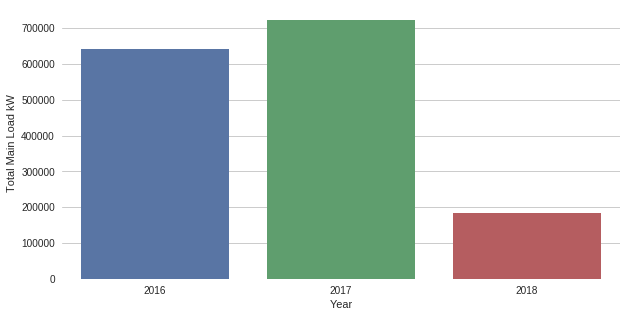

In [0]:
yearly_barplot = sns.barplot(x="year", y="Main Load [kWh]", data=year_consumption)

sns.despine(top=True, 
            left= True,
            bottom = True,
            trim=True)

yearly_barplot.set_xlabel("Year")
yearly_barplot.set_ylabel("Total Main Load kW")

In [0]:
print("2017 total consumption was a %.2f%% increase over the previous year." % ((year_consumption['Main Load [kWh]'][0]/year_consumption['Main Load [kWh]'][1] - 1)*100))

2017 total consumption was a 12.41% increase over the previous year.


Not comparing 2018 total to other year because there is no data in the dataset for every month of this year.

### Year of higher consumption

In [0]:
print("%s has the higher consumption, with a total of %.2f kW" %(year_consumption['year'][0], year_consumption['Main Load [kWh]'][0]))

2017 has the higher consumption, with a total of 722939.10 kW


# Simple forecast of the Time Series

## EDA

Starting the Exploratory Data Analysis by creating a copy of the dataset to work with.

In [0]:
df_EDA = df.copy()

Checking if "Date" and "Hour" features are equal.

In [0]:
df_EDA['Date'].equals(df_EDA['Hour'])

True

Setting "Date" as index, dropping "Date" and "Hour" and checking the result.

In [0]:
df_EDA.set_index(df_EDA['Date'], inplace=True)
df_EDA.drop(['Date', 'Hour'], axis=1, inplace=True)
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20447 entries, 2016-01-01 00:00:00 to 2018-05-01 23:00:00
Data columns (total 6 columns):
Main Load [kWh]    20447 non-null float64
day_of_week        20447 non-null int64
day_of_month       20447 non-null int64
week               20447 non-null int64
month              20447 non-null int64
year               20447 non-null int64
dtypes: float64(1), int64(5)
memory usage: 1.1 MB


In [0]:
df_EDA.head()

,Main Load [kWh],day_of_week,day_of_month,week,month,year
Date,,,,,,
2016-01-01 00:00:00,14.95,4,1,53,1,2016
2016-01-01 01:00:00,18.20,4,1,53,1,2016
2016-01-01 02:00:00,16.90,4,1,53,1,2016
2016-01-01 03:00:00,18.20,4,1,53,1,2016
2016-01-01 04:00:00,16.90,4,1,53,1,2016


Ensuring there is no null/NaN values in the dataset

In [0]:
df_EDA.isnull().sum()

Main Load [kWh]    0
day_of_week        0
day_of_month       0
week               0
month              0
year               0
dtype: int64

Having a look at basic stats.

In [0]:
df_EDA.describe()

,Main Load [kWh],day_of_week,day_of_month,week,month,year
count,20447.000000,20447.000000,20447.000000,20447.000000,20447.000000,20447.000000
mean,75.806429,3.001027,15.691153,24.132733,5.952707,2016.712378
std,64.886774,2.002041,8.799195,15.350931,3.513611,0.699195
min,1.300000,0.000000,1.000000,1.000000,1.000000,2016.000000
25%,15.600000,1.000000,8.000000,11.000000,3.000000,2016.000000
50%,66.300000,3.000000,16.000000,22.000000,6.000000,2017.000000
75%,117.000000,5.000000,23.000000,38.000000,9.000000,2017.000000
max,343.200000,6.000000,31.000000,53.000000,12.000000,2018.000000


*It seems there might be some peaks and low minimums in consumption.*

Plotting a boxplot to have a look at those extreme values.

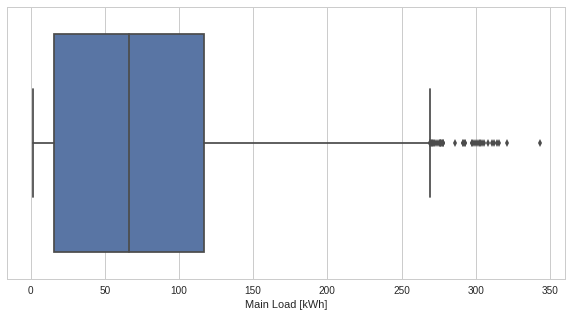

In [0]:
sns.boxplot(x = df_EDA['Main Load [kWh]'])

*There is some quite high values in the distribution.*

### Trend and Stationarity Analysis

Checking the trend and possible stationarity in the distribution by plotting the weekly means for the period.

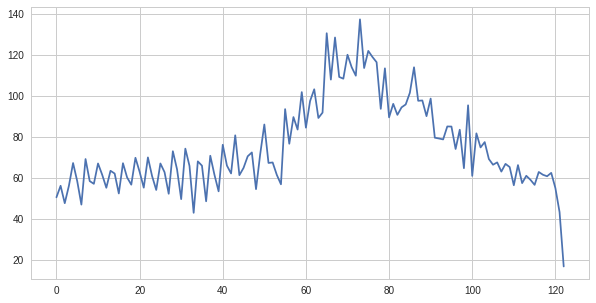

In [0]:
df_EDA.groupby(['week','year'], as_index=False).mean()['Main Load [kWh]'].plot()

*There is no consistent trend during period considered. Neither stationarity, as the distribution does not show stable mean, variance and autocorrelation over time.*

### Seasonality analysis

**Yearly**

Checking yearly tren by plotting consumption year-by-year.

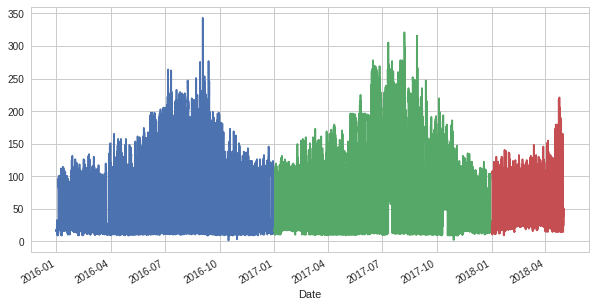

In [0]:
for year in df_EDA['year'].unique().tolist():  
  df_EDA[df_EDA['year'] == year]['Main Load [kWh]'].plot()

*There is a clear year seasonality, with peaks in consumption during summer time, and lows during winter.*

Plotting year consumption by month by making a pivot of the dataset on "month" and "year".

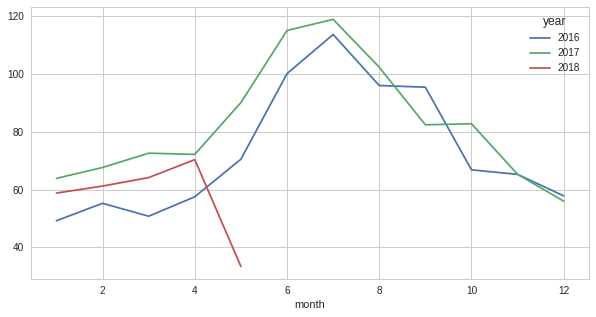

In [0]:
pd.pivot_table(df_EDA, 
               index='month', 
               columns = 'year', 
               values = 'Main Load [kWh]', 
               aggfunc=np.mean).plot()

*Seasonality is also clear in this plot, with the exception of May 2018.*

Plotting year consumption by week by making a pivot on "week" and "year".

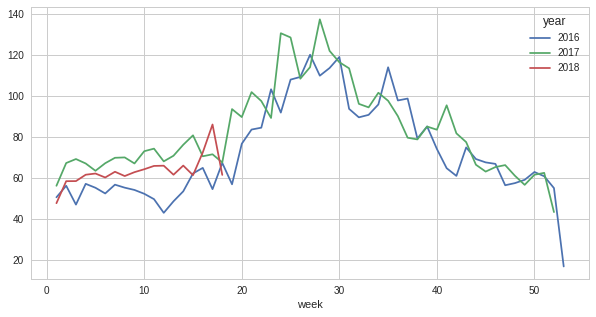

In [0]:
pd.pivot_table(df_EDA, 
               index='week', 
               columns = 'year', 
               values = 'Main Load [kWh]', 
               aggfunc=np.mean).plot()

*Above plot also shows year seasonality. May 2018 drop is not that prominent in this case.*


** Monthly **

Creating a new feature by concatenating "year" and "month", as strings, and encoding it, in order to have an unique value per month in the period.

In [0]:
df_EDA['year_month'] = labelmaker.fit_transform(df_EDA['year'].astype(str) + df_EDA['month'].astype(str))

Plotting year consumption by week by making a pivot on "day" and "year_moth".

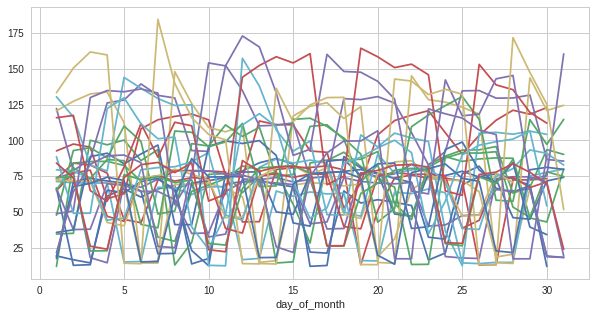

In [0]:
pd.pivot_table(df_EDA, 
               index='day_of_month', 
               columns = 'year_month', 
               values = 'Main Load [kWh]', 
               aggfunc=np.mean).plot(legend=None)

*The plot doesn't show a clear month seasonality.*

**Day of the week**

Creating a new feature by concatenating "year" and "week", as strings, and encoding it, in order to have an unique value per week in the period.

In [0]:
df_EDA['year_week'] = labelmaker.fit_transform(df_EDA['year'].astype(str) + df_EDA['week'].astype(str))

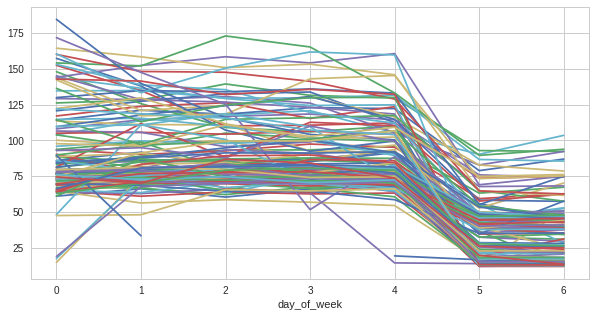

In [0]:
pd.pivot_table(df_EDA, 
               index = 'day_of_week', 
               columns = 'year_week', 
               values = 'Main Load [kWh]',
               aggfunc=np.mean).plot(legend=None)

Consumption drops significativelly during the weekend.

**Case of May, 2018 drop in consumption**

Checking the drop in consumption in May 2018 by plotting the weekly consmuption for April and May of this year.

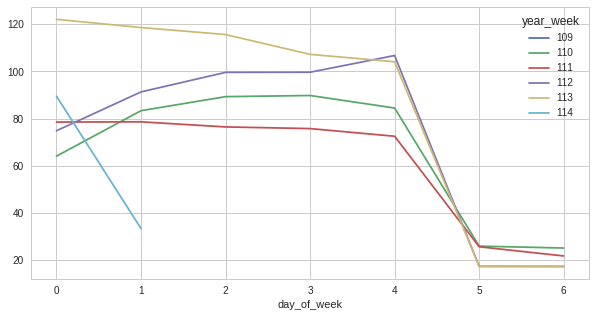

In [0]:
pd.pivot_table(df_EDA[(df_EDA['year'] == 2018) & (df_EDA['month'].isin([4,5]))], 
                             index = 'day_of_week', 
                             columns = 'year_week', 
                             values = 'Main Load [kWh]', 
                             aggfunc=np.mean).plot()

*There is a clear drop in the consumption on the last day of the dataset, Tuesday.*

In [0]:
df_EDA.tail()

,Main Load [kWh],day_of_week,day_of_month,week,month,year,year_month,year_week
Date,,,,,,,,
2018-05-01 19:00:00,46.8,1,1,18,5,2018,28,114
2018-05-01 20:00:00,50.7,1,1,18,5,2018,28,114
2018-05-01 21:00:00,37.7,1,1,18,5,2018,28,114
2018-05-01 22:00:00,29.9,1,1,18,5,2018,28,114
2018-05-01 23:00:00,24.7,1,1,18,5,2018,28,114


*Last day in the series is 1st of May, 2018. Labour day (May Day) is bank holidays in most countries. That, as the only observation for May 2018, may explain the drop in monthly consumption for that month, and its effect in the previous plot of yearly consumption by month.*

## Model

The model chosen for this time series is a polynomial regression, due to its simplicity and power when deployed together with feature engineering, feature selection, and regularization.

Starting to work in the model by creating a copy of the EDA dataset to work with, as in order to inherit the features extracted in that stage.

In [0]:
df_model = df_EDA.copy()
df_model.head()

,Main Load [kWh],day_of_week,day_of_month,week,month,year,year_month,year_week
Date,,,,,,,,
2016-01-01 00:00:00,14.95,4,1,53,1,2016,0,48
2016-01-01 01:00:00,18.20,4,1,53,1,2016,0,48
2016-01-01 02:00:00,16.90,4,1,53,1,2016,0,48
2016-01-01 03:00:00,18.20,4,1,53,1,2016,0,48
2016-01-01 04:00:00,16.90,4,1,53,1,2016,0,48


*  Extracting more features related to time and date, as hour and day of the year. 
*  Setting a new boolean feature for the weekend, this boolean does not include bank holidays, as there is no information on the location of the building. 
* Getting rid of the datetime index.
* And renaming labels column.

In [0]:
df_model['hour'] = df_model.index.hour
df_model['day_of_year'] = df_model.index.dayofyear
df_model['weekend'] = df_model['day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)
df_model.reset_index(drop=True,inplace=True)
df_model.rename({'Main Load [kWh]': 'y'}, axis = 1, inplace=True)


Setting the forecast horizon to 1 week by creating a week-long lag feature.

In [0]:
week_lag = 24*7

df_model['week_lag'] = df_model.y.shift(week_lag)

Dropping the NaN values generated by the creation of week_lag feature.

In [0]:
df_model.dropna(inplace=True)
print(df.shape[0] - df_model.shape[0], "first observations (consumptions per hour) dropped after setting the forecast horizon.")

168 first observations (consumptions per hour) dropped after setting the forecast horizon.


Setting train and test sizes and locating in the dataset the index which splits them.

In [0]:
test_size = 0.2
test_index = int(len(df_model)*(1-test_size))

Creating new features only from train set. 

In [0]:
def period_mean(df, grouper, feature):

    return dict(df.groupby(grouper)[feature].mean())

In [0]:
df_model['day_mean'] = list(map(period_mean(df_model[:test_index], 
                                            'day_of_week', 
                                            'y').get, 
                                df_model['day_of_week']))
df_model['week_mean'] = list(map(period_mean(df_model[:test_index], 
                                            'week', 
                                            'y').get, 
                                df_model['week']))
df_model['month_mean'] = list(map(period_mean(df_model[:test_index], 
                                            'month', 
                                            'y').get, 
                                df_model['month']))

In [0]:
df_model.head()

,y,day_of_week,day_of_month,week,month,year,year_month,year_week,hour,day_of_year,weekend,week_lag,day_mean,week_mean,month_mean
168,16.9,4,8,1,1,2016,0,0,0,8,0,14.95,91.746971,49.259167,58.187311
169,15.6,4,8,1,1,2016,0,0,1,8,0,18.20,91.746971,49.259167,58.187311
170,15.6,4,8,1,1,2016,0,0,2,8,0,16.90,91.746971,49.259167,58.187311
171,16.9,4,8,1,1,2016,0,0,3,8,0,18.20,91.746971,49.259167,58.187311
172,15.6,4,8,1,1,2016,0,0,4,8,0,16.90,91.746971,49.259167,58.187311


Analysing feature correlation in order to compare it with future automated feature selection.

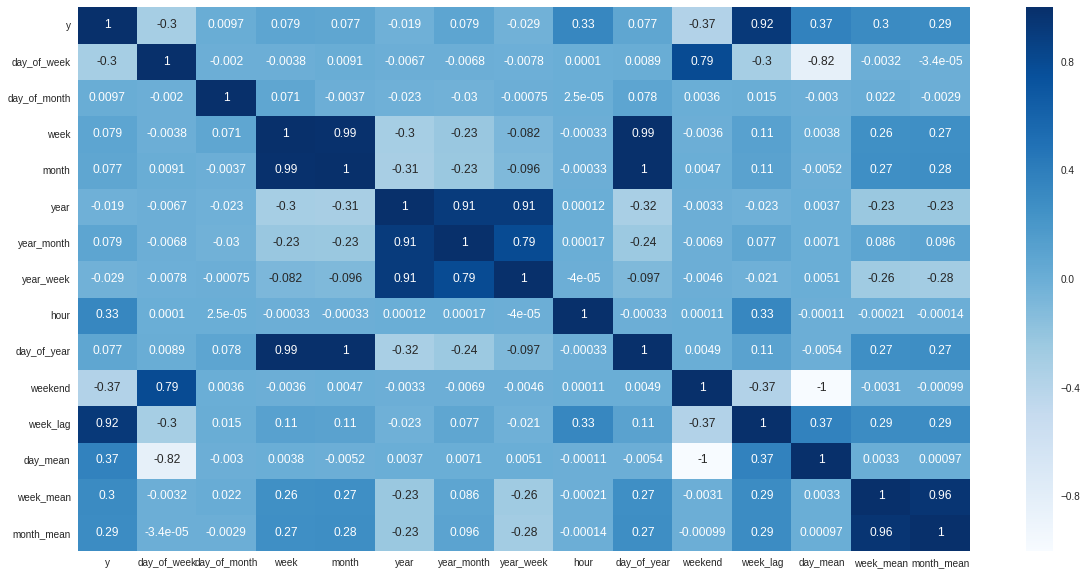

In [0]:
df_corr = df_model.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(df_corr, 
            xticklabels = df_corr.columns.values, 
            yticklabels = df_corr.columns.values, 
            cmap="Blues", 
            annot = True);

Train and test splitting

In [0]:
df_model = df_backup.copy()

In [0]:
y = df_model.y
X = df_model.drop('y', axis=1)

In [0]:
X_train = X.iloc[:test_index]
y_train = y.iloc[:test_index]
X_test = X.iloc[test_index:]
y_test = y.iloc[test_index:]

Scaling the data to easen the training

In [0]:
scaler = StandardScaler()

In [0]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Defining a metric as the mean of the proportion of the absolute errors over the actual labels.

In [0]:
def prediction_absolute_prop_error(y, y_pred): 
    return np.mean(np.abs((y - y_pred) / y))

Setting, TimeSeriesSplit, a variant of KFold for time series, to define the number of splits to use while performing cross-validation.

In [0]:
tscv = TimeSeriesSplit(n_splits=10)

Setting the model as Linear Regression with Lasso regularization, as it help preventing overfitting by forcing the features which contribute the less to the prediction to fade out by multiplying the sum of absolute values of the coefficients by the regularization parameter.

In [0]:
model = LassoCV()

Setting Recursive Feature Elimination with 1 step, so it drops 1 feature per iteration, in order to get a ranking of features which contribute the most to the prediction, and combined with TimeSeriesSplit. And proceeding with feature selection.

In [0]:
rfe = RFECV(estimator = model, 
            step = 1, 
            cv = tscv)

result = rfe.fit(X_train, y_train)

Checking Feature Selection results

In [0]:
print('Number of features selected: %s' % (result.n_features_))
print("Selected Features: %s" % (result.support_))
print("Feature Ranking: %s" % (result.ranking_))
print("Coefficients: %s"% (rfe.estimator_.coef_))

Number of features selected: 5
Selected Features: [False False False False False False False  True  True  True  True False
  True False]
Feature Ranking: [10  9  2  8  7  6  5  1  1  1  1  3  1  4]
Coefficients: [ 2.64567743 -1.75694685 -2.69973109 60.14131647  3.43422368]


In [0]:
print(df_model.columns.values[8])
print(df_model.columns.values[9])
print(df_model.columns.values[10])
print(df_model.columns.values[11])
print(df_model.columns.values[13])

hour
day_of_year
weekend
week_lag
week_mean


*The Recursive Feature Elimination has ranked above features as the ones that contribute the most to the prediction. Coefficient results also shows that week_lag is the feature which the highest weight assigned by a large difference. It also shows a correlation with the labels of 0.92 in the correlation matrix. In fact, RFE has chosen the features showing higher correlations with the label, as the rest of the features selected correlations are the following highest ones absolute terms.*

In [0]:
y_pred = rfe.predict(X_test)
print('Test set mean absolute proportion error: {:.2f}'.format(prediction_absolute_prop_error(y_pred, y_test)))
print('R2 score: {:.2f}'.format(r2_score(y_pred, y_test)))

Test set mean absolute proportion error: 0.20
R2 score: 0.82


*  Model scored 0.20 in Prediction MAPE, which means that model it's able to predict, in average, 80% of the actual value of the labels in the test set.
*   It also scored 0.82 in R2 metric, so the model predicts 82% of the variance of the labels in the test set.